Pranshu Thirani

220801





**Part 1: A simple linear regression: Power posing and testosterone**

In [44]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
df_pp = pd.read_csv('/content/df_powerpose_99f68d8a-2128-47c5-84c4-93af776c0468.csv')

# Calculating the change in testosterone levels after treatment
df_pp['delta'] = df_pp['testm2'] - df_pp['testm1']


# Defining the dependent variable (delta) and independent variable (hptreat)
# Mapping 'Low' and 'High' values to 0 and 1.
A = df_pp['hptreat'].map({'Low': 0, 'High': 1})
B = df_pp['delta']
# Adding a constant to the independent variable (intercept)
A = sm.add_constant(A)
# Fit the linear regression model
model = sm.OLS(B, A).fit()
# Interpreting the results
print("Summary of linear regression results:\n", model.summary())
# Interpretation
# A significantly positive coefficient for 'hptreat' suggests that high power posing is associated
# with a higher increase in testosterone levels compared to low power posing.
# To assess if this association is statistically significant, we check the p-value of
# the 'hptreat' coefficient. A value < 0.05 typically indicates statistical insignificance.

Summary of linear regression results:
                             OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.869
Date:                Wed, 03 Jul 2024   Prob (F-statistic):              0.180
Time:                        17:13:04   Log-Likelihood:                -171.48
No. Observations:                  39   AIC:                             347.0
Df Residuals:                      37   BIC:                             350.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Part 2: Poisson regression models and hypothesis**

Exercise 2.1:

Implementing the model in python, using variables alpha, beta and length of the sentence.

The function takes the input of length, beta and alpha, and returns a random value generated from the poisson distribution formed from the lambda obtained.

In [45]:
import numpy as np

# creating the crossings calculating function.
def calculate_crossings(sentence_length, alpha, beta):

 # Computing lambda_i. As log(lambda_i) = (alpha + (beta*sentence_length))
 lambda_i = np.exp(alpha + (beta * sentence_length))

 # Generating number of crossings from Poisson distribution of lambda_i, by taking random samples.
 crossings = np.random.poisson(lambda_i)
 return crossings


# Example Usage
sentence_length = 8 # sentence length
alpha = 0.4 # Example alpha (expected crossings for average length sentence)
beta = 0.05 # Example beta (change in crossings with sentence length)


num_crossings = calculate_crossings(sentence_length, alpha, beta)
print("Example Number of crossings:", num_crossings)


Example Number of crossings: 0


Example 2.2:

Taking Length of Sentence to be 4.

And assuming priors of alpha and beta being

α ∼ Normal (0.15, 0.1)

β ∼ Normal (0.25, 0.05)

I took 10,000 samples of number of crossings by implementing a function for the same and plotted the final distribution.

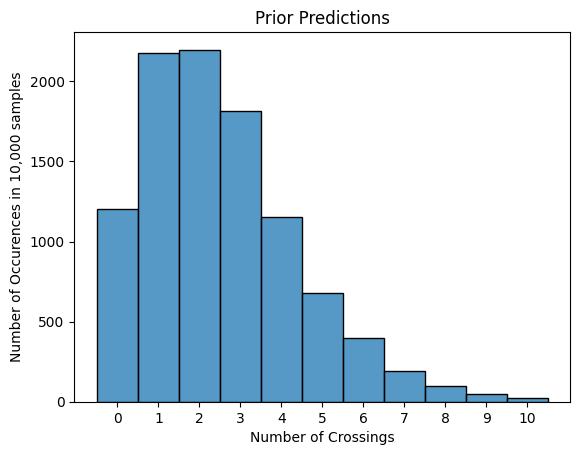

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_prior_predictions(sentence_length, samples=10000):
 # Defining prior distributions for alpha and beta
 alpha_prior = np.random.normal(0.15, 0.1, samples) # Prior for alpha
 beta_prior = np.random.normal(0.25, 0.05, samples) # Prior for beta

 predictions = []
 for alpha, beta in zip(alpha_prior, beta_prior):
    ni = calculate_crossings(alpha, beta, sentence_length)
    predictions.append(ni)
 return predictions

# Generating prior predictions for sentence length 4
sentence_length = 4
prior_predictions = generate_prior_predictions(sentence_length)

#Plotting the results+0

sns.histplot(prior_predictions, bins=np.arange(0, 12)-0.5, kde=False)  # Adjust bins for desired granularity
plt.title('Prior Predictions')
plt.xlabel('Number of Crossings')
plt.ylabel('Number of Occurences in 10,000 samples')
plt.xticks(range(0, 11))
plt.show()


Exercise 2.3:

In [47]:
!pip install pymc==4.1.6
import statsmodels.formula.api as smf
import pymc as pm
from sklearn.model_selection import KFold
import arviz as az

crossings = pd.read_csv('/content/crossings_24a167f3-2f8f-4f5c-bca9-884567bb1c33.csv')
crossings['Language'] = crossings['Language'].map({'English': 0, 'German': 1})

Parameter estimation with M1:

In [48]:
with pm.Model() as model_M1:
    alpha = pm.Normal('alpha', mu=0.15, sigma=0.1)
    beta = pm.Normal('beta', mu=0, sigma=0.15)
    mu = pm.math.exp(alpha + beta * crossings['s.length'])
    y_obs = pm.Poisson('y_obs', mu=mu, observed=crossings['nCross'])
    trace_M1 = pm.sample(2000, tune=1000, cores=2, random_seed=42)
    print(pm.summary(trace_M1))



        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -1.045  0.048  -1.134   -0.953      0.002    0.001     766.0     925.0   
beta   0.125  0.003   0.119    0.131      0.000    0.000     763.0     707.0   

       r_hat  
alpha    1.0  
beta     1.0  


M1 estimates Alpha to have mean -1.045 and SD = 0.048.


M1 estimates Beta to have mean 0.125 and SD = 0.003
.


Parameter estimation with M2:

In [49]:
with pm.Model() as model_M2:
    alpha = pm.Normal('alpha', mu=0.15, sigma=0.1)
    beta = pm.Normal('beta', mu=0, sigma=0.15)
    beta_language = pm.Normal('beta_language', mu=0, sigma=0.15)
    beta_interact = pm.Normal('beta_interact', mu=0, sigma=0.15)
    mu = pm.math.exp(alpha + beta * crossings['s.length'] + beta_language * crossings['Language'] + beta_interact * crossings['s.length'] * crossings['Language'])
    y_obs = pm.Poisson('y_obs', mu=mu, observed=crossings['nCross'])
    trace_M2 = pm.sample(2000, tune=1000, cores=2, random_seed=42)
    print(pm.summary(trace_M2))


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         -0.664  0.057  -0.778   -0.563      0.002    0.001    1099.0   
beta           0.081  0.004   0.074    0.090      0.000    0.000    1063.0   
beta_language -0.946  0.088  -1.118   -0.788      0.003    0.002     941.0   
beta_interact  0.092  0.006   0.081    0.103      0.000    0.000     947.0   

               ess_tail  r_hat  
alpha            1335.0    1.0  
beta             1308.0    1.0  
beta_language    1033.0    1.0  
beta_interact    1040.0    1.0  


Exercise 2.4:

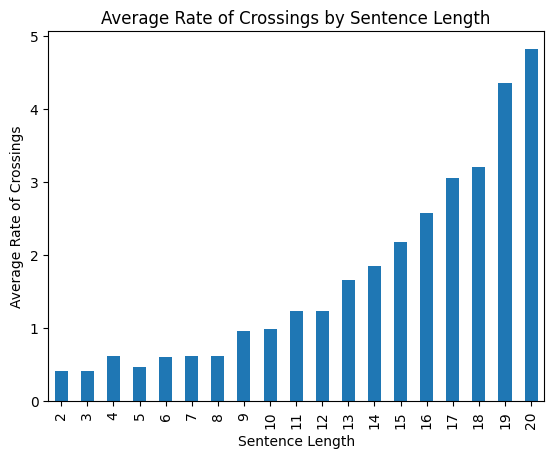

In [51]:
from sklearn.model_selection import KFold


# Load the data
crossings_data = pd.read_csv('/content/crossings_24a167f3-2f8f-4f5c-bca9-884567bb1c33.csv')

# Visualize the average rate of crossings by sentence length by bar graph
crossings_data.groupby('s.length')['nCross'].mean().plot(kind='bar')
plt.xlabel('Sentence Length')
plt.ylabel('Average Rate of Crossings')
plt.title('Average Rate of Crossings by Sentence Length')
plt.show()

# Center the predictors sentence length and language id
crossings_data['sentence_length_centered'] = crossings_data['s.length'] - crossings_data['s.length'].mean()
crossings_data['language_ind_centered'] = crossings_data['s.id'] - crossings_data['s.id'].mean()


In [52]:
# Set up k-fold cross-validation
k = 10  # Number of folds = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Initialize arrays to store log predictive densities(lpd)
lpd_M1 = np.zeros(k)
lpd_M2 = np.zeros(k)

# Function to calculate log predictive density
def calculate_lpd(model, X_test, y_test):
    predictions = model.get_prediction(X_test)             # test data taken
    mean_pred = predictions.predicted_mean                 # mean of test data
    lpd = np.sum(y_test * np.log(mean_pred) - mean_pred)   # Poisson log likelihood
    return lpd


In [53]:

# Fit the Models on training data and evaluate on test tata
for i, (train_index, test_index) in enumerate(kf.split(crossings_data)):
    # Split the data into training and test sets
    train_data, test_data = crossings_data.iloc[train_index], crossings_data.iloc[test_index]

    ####  M1  ####

    # Prepare training and test data for Model M1
    X_train_M1 = train_data[['sentence_length_centered']]
    X_train_M1 = sm.add_constant(X_train_M1)
    y_train_M1 = train_data['nCross']
    X_test_M1 = test_data[['sentence_length_centered']]
    X_test_M1 = sm.add_constant(X_test_M1)
    y_test_M1 = test_data['nCross']

    # Fit Model M1
    model_M1 = sm.GLM(y_train_M1, X_train_M1, family=sm.families.Poisson()).fit()

    # Calculate log predictive density for Model M1
    lpd_M1[i] = calculate_lpd(model_M1, X_test_M1, y_test_M1)

    ####  M2  ####

    # Prepare training and test data for Model M2
    X_train_M2 = train_data[['sentence_length_centered', 'language_ind_centered']].copy()
    X_train_M2['interaction'] = X_train_M2['sentence_length_centered'] * X_train_M2['language_ind_centered']
    X_train_M2 = sm.add_constant(X_train_M2)
    y_train_M2 = train_data['nCross']
    X_test_M2 = test_data[['sentence_length_centered', 'language_ind_centered']].copy()
    X_test_M2['interaction'] = X_test_M2['sentence_length_centered'] * X_test_M2['language_ind_centered']
    X_test_M2 = sm.add_constant(X_test_M2)
    y_test_M2 = test_data['nCross']

    # Fit Model M2
    model_M2 = sm.GLM(y_train_M2, X_train_M2, family=sm.families.Poisson()).fit()

    # Calculate log predictive density for Model M2
    lpd_M2[i] = calculate_lpd(model_M2, X_test_M2, y_test_M2)



In [54]:
# Calculate the mean log predictive density for both models M1 & M2
mean_lpd_M1 = np.mean(lpd_M1)
mean_lpd_M2 = np.mean(lpd_M2)

print(f'Mean log predictive density for Model M1: {mean_lpd_M1}')
print(f'Mean log predictive density for Model M2: {mean_lpd_M2}')

# Evidence in favor of M2 over M1
evidence = mean_lpd_M2 - mean_lpd_M1
print(f'Evidence in favor of Model M2 over Model M1: {evidence}')


Mean log predictive density for Model M1: -65.64008731874553
Mean log predictive density for Model M2: -65.38386264638359
Evidence in favor of Model M2 over Model M1: 0.25622467236193813


Data Visualization: We begin by visualizing the average rate of crossings by sentence length to gain an initial understanding of the data, represented as a bar graph.

Centering Predictors: We center the predictors, s.length (sentence length) and s.id (language id), so they have a mean of zero, which is a standard preprocessing step.

k-fold Cross-Validation Setup: Using KFold from sklearn.model_selection, we set up a 10-fold cross-validation (k=10). This splits the data into 10 folds for training and testing.

Model Fitting and Evaluation: Within the cross-validation loop:

We fit Model M1 and Model M2 using sm.GLM from statsmodels.api, specifying the Poisson family for the likelihood.
For each fold, we calculate the log predictive density (lpd) using a helper function calculate_lpd, which computes the Poisson log likelihood based on predicted means.
Comparing Models: After cross-validation, we compute the mean log predictive density for both Model M1 and Model M2 across all folds.

Evidence Calculation: Finally, we calculate the evidence in favor of Model M2 over Model M1 by subtracting their mean log predictive densities.